In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.model_selection import TimeSeriesSplit
# import xgboost as xgb
from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.svm import SVR
from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV
from collections import Counter
from itertools import chain
import swifter
from tqdm import tqdm

from backtest_functions import *

### preprocess

In [2]:
path_to_folder = "C:/Users/phku0/Quant_Project"
df = pd.read_parquet(path_to_folder+'/data_processing/v3_cleaned.parquet')

print(df.shape)
print(df.columns)

(872206, 40)
Index(['month', 'cusip', 'ratingOverall', 'ratingCareerOpportunities',
       'ratingCompensationAndBenefits', 'ratingCultureAndValues',
       'ratingSeniorLeadership', 'ratingWorkLifeBalance',
       'ratingDiversityAndInclusion', 'ratingBusinessOutlook', 'ratingCeo',
       'ratingRecommendToFriend', 'summary_length', 'pros_length',
       'cons_length', 'advice_length', 'summary_token_count',
       'pros_token_count', 'cons_token_count', 'advice_token_count',
       'summary_sentiment', 'pros_sentiment', 'cons_sentiment',
       'advice_sentiment', 'summary_token', 'pros_token', 'cons_token',
       'advice_token', 'innovative_llama', 'integrity_llama', 'quality_llama',
       'respect_llama', 'teamwork_llama', 'review_count', 'vol_forward_1m',
       'return_forward_1m', 'gsector', 'ggroup', 'gind', 'gsubind'],
      dtype='object')


In [3]:
df.rename({'month':'year_month'}, axis=1, inplace=True)
df = df[df['year_month'] >= "2014-01"]

In [4]:
df = df[['year_month', 'cusip', 'review_count', 'ratingOverall', 'summary_token', 'pros_token', 'cons_token', 'advice_token', 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment', 'return_forward_1m']]
df.dropna(subset=['ratingOverall'], inplace=True)
df = df.reset_index(drop=True)

In [5]:
df.head(2)

,year_month,cusip,review_count,ratingOverall,summary_token,pros_token,cons_token,advice_token,summary_sentiment,pros_sentiment,cons_sentiment,advice_sentiment,return_forward_1m
0,2014-02,10055710,1,3.0,"[[amaze, people.overworked, underpaid]]","[[people, culture, fun, supportive, talented, ...","[[increase, goal, without, additional, compens...","[[increase, compensation, increase, expectatio...",0.5008,0.9773,-0.6254,-0.721834,0.033708
1,2014-04,10055710,2,5.0,"[[brewery, ambassador], [wonderful, company]]","[[absolutely, amaze, experience, job, dynamic,...","[[none, see, yes, customer, service, time, amo...","[[], []]",0.4777,0.9795,0.0510,0.051039,-0.128557


In [6]:
all_summary_tokens = list(chain.from_iterable(chain.from_iterable(df['summary_token'])))
summary_token_freq = Counter(all_summary_tokens)

all_pros_tokens = list(chain.from_iterable(chain.from_iterable(df['pros_token'])))
pros_token_freq = Counter(all_pros_tokens)

all_cons_tokens = list(chain.from_iterable(chain.from_iterable(df['cons_token'])))
cons_token_freq = Counter(all_cons_tokens)

all_advice_tokens = list(chain.from_iterable(chain.from_iterable(df['advice_token'])))
advice_token_freq = Counter(all_advice_tokens)

In [7]:
def evaluate_tokens(row):
  positive_tokens = []
  neutral_tokens = []
  negative_tokens = []

  if row['pros_sentiment'] >= 0.7:
    positive_tokens.extend(row['pros_token'])
  if row['summary_sentiment'] >= 0.7:
    positive_tokens.extend(row['summary_token'])

  if row['pros_sentiment'] >= -0.25 and row['pros_sentiment'] <= 0.25:
    neutral_tokens.extend(row['pros_token'])
  if row['cons_sentiment'] >= -0.25 and row['cons_sentiment'] <= 0.25:
    neutral_tokens.extend(row['cons_token'])
  if row['summary_sentiment'] >= -0.25 and row['summary_sentiment'] <= 0.25:
    neutral_tokens.extend(row['summary_token'])

  if row['cons_sentiment'] <= -0.7:
    negative_tokens.extend(row['cons_token'])
  if row['summary_sentiment'] <= -0.7:
    negative_tokens.extend(row['summary_token'])

  return positive_tokens, neutral_tokens, negative_tokens

df[['positive_tokens', 'neutral_tokens', 'negative_tokens']] = df[['summary_token', 'pros_token', 'cons_token', 'summary_sentiment', 'pros_sentiment', 'cons_sentiment']].swifter.apply(lambda row: pd.Series(evaluate_tokens(row)), axis=1)

Pandas Apply:   0%|          | 0/128098 [00:00<?, ?it/s]

In [8]:
people = ['people', 'employee', 'team', 'associate', 'manager', 'customer', 'coworkers', 'staff']
culture = ['culture', 'environment', 'life', 'friendly', 'fun', 'experience', 'flexible', 'leadership']
growth = ['career', 'opportunity', 'growth', 'learn', 'training']
work = ['work', 'job', 'company', 'management', 'sale', 'service', 'engineer', 'time', 'hour', 'schedule', 'day', 'technology', 'product']
positive_adj = ['great', 'good', 'best', 'excellent', 'nice', 'well', 'really', 'help', 'new', 'care', 'easy', 'many', 'free']
negative_adj = ['bad', 'low', 'need', 'lack', 'long', 'even', 'stop']

In [9]:
df.drop(columns=['summary_token', 'pros_token', 'cons_token', 'neutral_tokens'], inplace=True)

In [10]:
df.head()

,year_month,cusip,review_count,ratingOverall,advice_token,summary_sentiment,pros_sentiment,cons_sentiment,advice_sentiment,return_forward_1m,positive_tokens,negative_tokens
0,2014-02,10055710,1,3.0,"[[increase, compensation, increase, expectatio...",0.5008,0.9773,-0.6254,-0.721834,0.033708,"[[people, culture, fun, supportive, talented, ...",[]
1,2014-04,10055710,2,5.0,"[[], []]",0.4777,0.9795,0.0510,0.051039,-0.128557,"[[absolutely, amaze, experience, job, dynamic,...",[]
2,2014-05,10055710,1,4.0,"[[review, align, company, strategy, goal, metr...",0.0000,0.9504,-0.7412,-0.776726,0.042488,"[[people, make, company, strong, bond, within,...","[[poor, internal, system, process, people, att..."
3,2014-06,10055710,1,5.0,"[[must, address, comp, gap]]",0.8757,0.8225,-0.5579,-0.557864,-0.013958,"[[bbc, environment, learn, advance, career, ev...",[]
4,2014-08,10055710,1,4.0,"[[stop, put, line, someone, go, get, seriously...",0.7253,0.9532,-0.5046,0.000000,0.003531,"[[job, sam, adam, something, proud, good, comp...",[]


In [11]:
def classify_tokens_count(row):
  positive_tokens = row['positive_tokens']
  negative_tokens = row['negative_tokens']

  people_positive_count = 0
  culture_positive_count = 0
  growth_positive_count = 0
  work_positive_count = 0

  people_negative_count = 0
  culture_negative_count = 0
  growth_negative_count = 0
  work_negative_count = 0

  positive_adj_count = 0
  negative_adj_count = 0
  
  for tokens in positive_tokens:
    if any(token in people for token in tokens):
      people_positive_count += 1
    if any(token in culture for token in tokens):
      culture_positive_count += 1
    if any(token in growth for token in tokens):
      growth_positive_count += 1
    if any(token in work for token in tokens):
      work_positive_count += 1
    if any(token in positive_adj for token in tokens):
      positive_adj_count += 1
    if any(token in negative_adj for token in tokens):
      negative_adj_count += 1

  for tokens in negative_tokens:
    if any(token in people for token in tokens):
      people_negative_count += 1
    if any(token in culture for token in tokens):
      culture_negative_count += 1
    if any(token in growth for token in tokens):
      growth_negative_count += 1
    if any(token in work for token in tokens):
      work_negative_count += 1
    if any(token in positive_adj for token in tokens):
      positive_adj_count += 1
    if any(token in negative_adj for token in tokens):
      negative_adj_count += 1

  cols = [people_positive_count, culture_positive_count, growth_positive_count, work_positive_count,
          people_negative_count, culture_negative_count, growth_negative_count, work_negative_count,
          positive_adj_count, negative_adj_count]
  
  return pd.Series(cols)

df[['people_positive_count', 'culture_positive_count', 'growth_positive_count', 'work_positive_count',
    'people_negative_count', 'culture_negative_count', 'growth_negative_count', 'work_negative_count',
    'positive_adj_count', 'negative_adj_count']] = df.apply(classify_tokens_count, axis=1)

In [12]:
df.drop(columns=['advice_token', 'positive_tokens', 'negative_tokens', 'ratingOverall', 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment'], inplace=True)

In [13]:
df.head()

,year_month,cusip,review_count,return_forward_1m,people_positive_count,culture_positive_count,growth_positive_count,work_positive_count,people_negative_count,culture_negative_count,growth_negative_count,work_negative_count,positive_adj_count,negative_adj_count
0,2014-02,10055710,1,0.033708,1,1,1,1,0,0,0,0,1,0
1,2014-04,10055710,2,-0.128557,1,1,2,1,0,0,0,0,2,0
2,2014-05,10055710,1,0.042488,1,1,1,1,1,1,1,1,1,1
3,2014-06,10055710,1,-0.013958,0,2,1,2,0,0,0,0,0,0
4,2014-08,10055710,1,0.003531,0,0,1,2,0,0,0,0,2,0


In [14]:
### cal ratio instead of using absolute value
### eg people_positive_count / review_count
### filter review_count

### smooth

In [15]:
df.columns

Index(['year_month', 'cusip', 'review_count', 'return_forward_1m',
       'people_positive_count', 'culture_positive_count',
       'growth_positive_count', 'work_positive_count', 'people_negative_count',
       'culture_negative_count', 'growth_negative_count',
       'work_negative_count', 'positive_adj_count', 'negative_adj_count'],
      dtype='object')

In [16]:
cols = ['people_positive_count', 'culture_positive_count',
       'growth_positive_count', 'work_positive_count', 'people_negative_count',
       'culture_negative_count', 'growth_negative_count',
       'work_negative_count', 'positive_adj_count', 'negative_adj_count']

for col in cols:
  df[col] = np.where(df.review_count >= 10, df[col], np.NaN)

In [19]:
cols = ['people_positive_count', 'culture_positive_count',
       'growth_positive_count', 'work_positive_count', 'people_negative_count',
       'culture_negative_count', 'growth_negative_count',
       'work_negative_count', 'positive_adj_count', 'negative_adj_count']

smooth_df = df.copy()

for feature in tqdm(cols):
  factor_xnd = smooth_df[['year_month', 'cusip', feature]].pivot(index='year_month', columns='cusip', values=feature)
  factor_xnd = neutralise_by_group(factor_xnd, "gsubind")
  factor_xnd = factor_xnd.rolling(12, min_periods=1).mean()
  factor_long = factor_xnd.reset_index().melt(id_vars='year_month', var_name='cusip', value_name=feature)

  smooth_df.drop(columns=feature, inplace=True)
  smooth_df = smooth_df.merge(factor_long, on=['year_month', 'cusip'], how='left', suffixes=('', '_transformed'))
  smooth_df.rename(columns={feature + '_transformed': feature}, inplace=True)

100%|██████████| 10/10 [00:31<00:00,  3.11s/it]


In [24]:
df = df.dropna()
df = df.reset_index(drop=True)

In [25]:
df

,year_month,cusip,review_count,return_forward_1m,people_positive_count,culture_positive_count,growth_positive_count,work_positive_count,people_negative_count,culture_negative_count,growth_negative_count,work_negative_count,positive_adj_count,negative_adj_count
0,2014-02,10113710,13,0.032061,4.0,2.0,2.0,6.0,0.0,0.0,0.0,0.0,9.0,0.0
1,2014-08,10113710,10,-0.068610,4.0,2.0,2.0,8.0,0.0,0.0,0.0,0.0,7.0,1.0
2,2014-09,10113710,11,0.124469,8.0,4.0,3.0,9.0,0.0,0.0,0.0,0.0,8.0,0.0
3,2015-01,10113710,15,0.141121,6.0,8.0,4.0,13.0,0.0,0.0,0.0,0.0,12.0,1.0
4,2015-03,10113710,17,0.003945,9.0,5.0,5.0,13.0,0.0,0.0,0.0,0.0,13.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30826,2014-07,G5960L10,21,0.034175,6.0,7.0,6.0,16.0,0.0,0.0,0.0,0.0,16.0,1.0
30827,2014-08,G5960L10,16,-0.029757,8.0,6.0,3.0,12.0,0.0,0.0,0.0,0.0,11.0,2.0
30828,2014-09,G5960L10,12,0.105612,6.0,5.0,0.0,9.0,0.0,0.0,0.0,0.0,8.0,0.0
30829,2014-10,G5960L10,10,0.083774,6.0,3.0,2.0,6.0,0.0,0.0,0.0,0.0,8.0,0.0


### model

In [26]:
train = df[df['year_month']<'2018-01']
test = df[df['year_month']>='2018-01']

print(len(train))
print(len(test))

print(train.groupby('year_month')['review_count'].sum().sum())
print(test.groupby('year_month')['review_count'].sum().sum())

11751
19080
415572
777371


In [27]:
X_train = train.drop(columns=['year_month', 'cusip', 'review_count', 'return_forward_1m'])
y_train = train['return_forward_1m']

X_test = test.drop(columns=['year_month', 'cusip', 'review_count', 'return_forward_1m'])
y_test = test['return_forward_1m']

model = LinearRegression()
model = XGBRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')

Mean Squared Error: 0.029337297580901804


In [28]:
y_pred_series = pd.Series(y_pred, index=X_test.index, name='y_pred')
predicted_df = pd.concat([df[['year_month', 'cusip', 'return_forward_1m']], y_pred_series], axis=1)
predicted_df.head()

,year_month,cusip,return_forward_1m,y_pred
0,2014-02,10113710,0.032061,NaN
1,2014-08,10113710,-0.068610,NaN
2,2014-09,10113710,0.124469,NaN
3,2015-01,10113710,0.141121,NaN
4,2015-03,10113710,0.003945,NaN


In [29]:
def getRank(df, group_level):
  df['fyear'] = df['year_month'].dt.year

  df_GICS = pd.read_parquet(path_to_folder+'/data_processing/mapping_cusip_GICS.parquet')
  df_GICS = df_GICS[['cusip', 'fyear', group_level]]
  df = df.merge(df_GICS, on=['cusip', 'fyear'], how='left')

  df['pred_rank'] = df.groupby('gsubind')['y_pred'].rank(ascending=False)

  df = df.drop(columns=['fyear', group_level])
  return df


In [30]:
df_ranked = getRank(predicted_df, 'gsubind')

In [31]:
df_ranked.head()

,year_month,cusip,return_forward_1m,y_pred,pred_rank
0,2014-02,10113710,0.032061,NaN,NaN
1,2014-08,10113710,-0.068610,NaN,NaN
2,2014-09,10113710,0.124469,NaN,NaN
3,2015-01,10113710,0.141121,NaN,NaN
4,2015-03,10113710,0.003945,NaN,NaN


### backtest

Overall Annual Sharpe Ratio: -0.054457339218473545
--------------
Yearly Sharpe Ratio
year_month
2014         NaN
2015         NaN
2016         NaN
2017         NaN
2018   -1.070559
2019    1.327136
2020   -0.139581
2021    0.517830
2022   -0.298660
dtype: float64
--------------
Yearly Return (%)
year_month
2014    0.000000
2015    0.000000
2016    0.000000
2017    0.000000
2018   -2.542895
2019    1.673921
2020   -0.392233
2021    0.839244
2022   -0.285150
dtype: float64


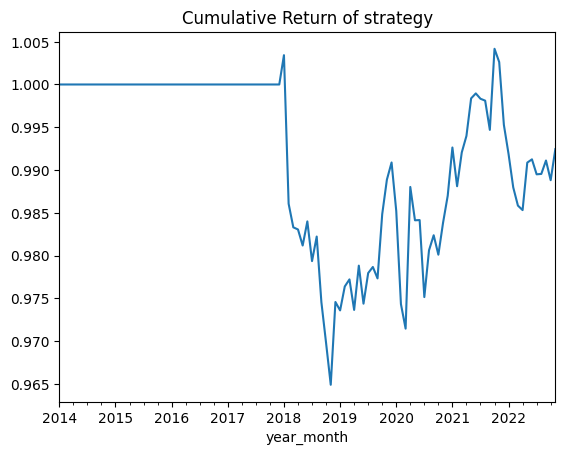

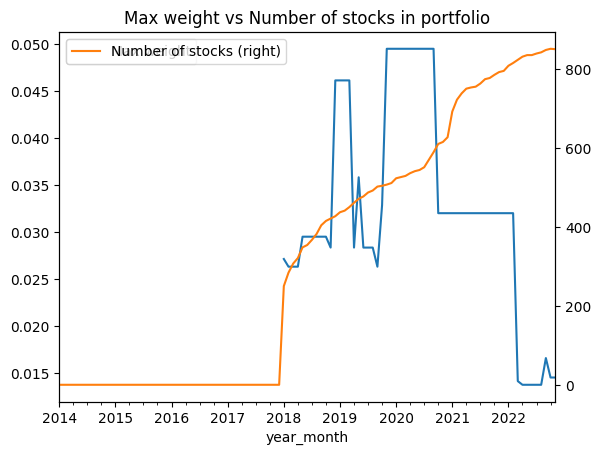

In [32]:
return_xnd = df_ranked[['year_month','cusip','return_forward_1m']].pivot(index = 'year_month', columns = 'cusip', values = 'return_forward_1m')

factor = 'pred_rank'

factor_xnd = df_ranked[['year_month','cusip',factor]].pivot(index = 'year_month', columns = 'cusip', values = factor)
factor_xnd = neutralise_by_group(factor_xnd, "gsubind")
factor_xnd = factor_xnd.rolling(36, min_periods = 1).mean()

portfolio_return = run_backtest(return_xnd, factor_xnd)
plot_backtest(portfolio_return)
plot_weights(factor_xnd)